In [135]:
from os import path

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic_2d

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

from pyia import GaiaData

In [12]:
galcen_frame = gc.get_galactocentric2019()

### APOGEE sample:

In [284]:
dr16 = at.Table.read(path.expanduser('~/data/APOGEE_DR16/allStarLite-r12-l33.fits'))

nn = at.Table.read(path.expanduser('~/data/APOGEE_DR16/apogee_astroNN-DR16.fits'))
nn = nn[(np.isfinite(nn['ra']) & np.isfinite(nn['dec']) & np.isfinite(nn['dist']) &
         (np.isfinite(nn['pmra']) & np.isfinite(nn['pmdec']) & np.isfinite(nn['vhelio_avg']) &
         ((nn['dist_error'] / nn['dist']) < 0.25)) &
         (nn['dist']*u.pc < 100.*u.kpc))]
nn.rename_column('apogee_id', 'APOGEE_ID')

_nn = at.join(dr16, nn, keys='APOGEE_ID', 
              uniq_col_name='{col_name}{table_name}',
              table_names=['', '_bovy'])
nn = _nn
nn = nn[np.unique(nn['APOGEE_ID'], return_index=True)[1]]

nn = nn[(nn['M_H'] > -2.5) & (nn['M_H'] < 1) &
        (nn['ALPHA_M'] > -3) & (nn['ALPHA_M'] < 3)]

c = coord.SkyCoord(nn['ra']*u.deg, nn['dec']*u.deg,
                   distance=nn['dist']*u.pc,
                   pm_ra_cosdec=nn['pmra']*u.mas/u.yr,
                   pm_dec=nn['pmdec']*u.mas/u.yr,
                   radial_velocity=nn['vhelio_avg']*u.km/u.s)

/Users/apricewhelan/anaconda/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/apricewhelan/anaconda/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


### Gaia RV sample:

In [285]:
# g = GaiaData('/Users/apricewhelan/data/GaiaDR2/rv-good-plx.fits')
# bprp0 = (g.get_BP0() - g.get_RP0()).value
# mg0 = g.get_G0().value - g.distmod.value

# # crude main sequence cut:
# # nodes = np.array([(0.4, 4), (1, 4), (2, 7.5), (1.75, 9)])
# # cmd_path = mpl.path.Path(nodes)
# # X0 = np.stack((bprp0, mg0)).T
# # cmd_mask = cmd_path.contains_points(X0)

# # crude RGB cut:
# cmd_mask = (mg0 < 4) & (bprp0 > 1)

# c = g.get_skycoord()
# c = c[cmd_mask]

# galcen = c.transform_to(galcen_frame)
# w0 = gd.PhaseSpacePosition(galcen.data)

# z_mask = np.abs(galcen.z < 1*u.kpc)
# w0 = w0[z_mask]
# galcen = galcen[z_mask]
# z_mask.sum()

# phi = galcen.represent_as('cylindrical').phi

# vlsr = 240 * u.km/u.s
# Lz = w0.angular_momentum()[2]
# Rg = -(Lz / vlsr).to(u.kpc)

# xg = -Rg * np.cos(phi)
# yg = Rg * np.sin(phi)

In [286]:
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# fin_mask = np.all(np.isfinite(X0), axis=1)
# ax.hist2d(X0[fin_mask, 0], X0[fin_mask, 1],
#           bins=(np.linspace(-1, 3, 128),
#                 np.linspace(-4, 12, 128)), 
#           norm=mpl.colors.LogNorm());
# ax.plot(X0[fin_mask & cmd_mask, 0], X0[fin_mask & cmd_mask, 1],
#         marker='o', ls='none', mew=0, color='tab:blue', ms=1., alpha=0.1)
# ax.set_xlim(-1, 3)
# ax.set_ylim(12, -4)

In [288]:
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# # pix_size = [0.08, 0.02] * u.kpc
# pix_size = [0.05, 0.05] * u.kpc
# H, xe, ye = np.histogram2d(xg.to_value(u.kpc), 
#                            yg.to_value(u.kpc), 
#                            bins=(np.arange(2, 12+1e-3, pix_size[0].value),
#                                  np.arange(-3, 3+1e-3, pix_size[1].value)))

# # H = unsharp_mask(H, pix_size=pix_size, strength=1., sigma=500*u.pc)
# # H = enhance(H, sigma=500*u.pc, pix_size=pix_size)

# pcl = np.percentile(H.ravel(), [5, 99])
# ax.pcolormesh(xe, ye, H.T,
# #               norm=mpl.colors.LogNorm())
#               vmin=pcl[0], vmax=pcl[1], cmap='magma');

# ax.set_xlabel('$x_g$')
# ax.set_ylabel('$y_g$')

# # fig.savefig('xgyg_gaia_rv.png', dpi=300)

---

In [306]:
galcen = c.transform_to(galcen_frame)
w0 = gd.PhaseSpacePosition(galcen.data)

z_mask = np.abs(galcen.z) < 1*u.kpc
w0 = w0[z_mask]
galcen = galcen[z_mask]
z_mask.sum()

254464

In [307]:
phi = galcen.represent_as('cylindrical').phi

vlsr = 240 * u.km/u.s
Lz = w0.angular_momentum()[2]
Rg = -(Lz / vlsr).to(u.kpc)

In [308]:
xg = -Rg * np.cos(phi)
yg = Rg * np.sin(phi)

In [309]:
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

In [310]:
def smoothed(H, pix_size, sigma):
    sigma = np.atleast_1d((sigma / pix_size).decompose().value)
    
    if len(sigma) == 1:
        kernel = Gaussian2DKernel(x_stddev=sigma[0])
    else:
        kernel = Gaussian2DKernel(*sigma)
        
    return convolve(H, kernel)

def unsharp_mask(H, pix_size, strength=1, sigma=500*u.pc):
    return H + strength * (H - smoothed(H, pix_size, sigma))

def enhance(H, pix_size, sigma=500*u.pc):
    return H - smoothed(H, pix_size, sigma)

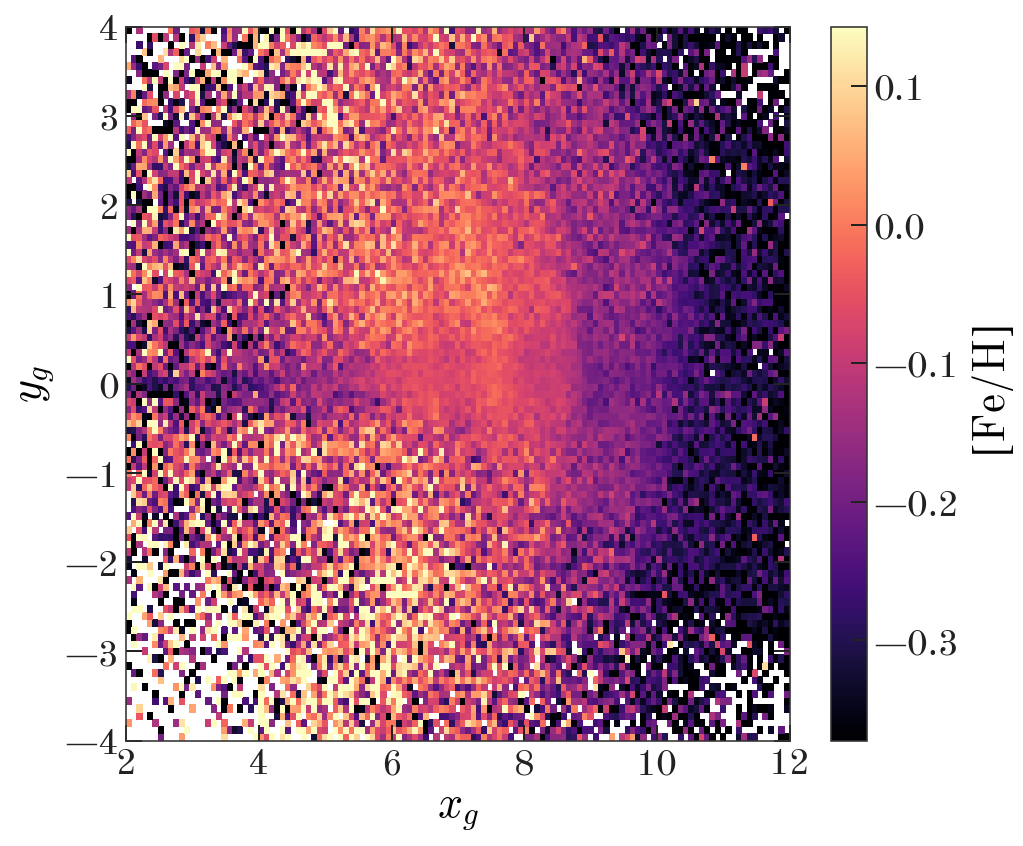

In [335]:
fig, ax = plt.subplots(1, 1, figsize=(7.2, 6))

# H, xe, ye = np.histogram2d(xg.to_value(u.kpc), 
#                            yg.to_value(u.kpc), 
#                            bins=(np.arange(2, 12+1e-3, 0.08),
#                                  np.arange(-1, 1+1e-3, 0.02)))

stat = binned_statistic_2d(xg.to_value(u.kpc), 
                           yg.to_value(u.kpc),
                           nn['M_H'][z_mask],
#                            bins=(np.arange(-5, 15+1e-3, 0.08),
#                                  np.arange(-10, 10+1e-3, 0.08)))
                           bins=(np.arange(2, 12+1e-3, 0.08),
                                 np.arange(-4, 4+1e-3, 0.08)))
H, xe, ye = (stat.statistic, stat.x_edge, stat.y_edge)

# H = enhance(H, pix_size=0.05*u.kpc, sigma=250*u.pc)
# H = unsharp_mask(H, pix_size=0.05*u.kpc, sigma=250*u.pc)

pcl = np.nanpercentile(nn['M_H'][z_mask], [15, 85])
# pcl = np.nanpercentile(H.T.ravel(), [15, 85])
im = ax.pcolormesh(xe, ye, H.T, 
                   vmin=pcl[0], vmax=pcl[1])

# H = unsharp_mask(H, strength=1., sigma=2)
# H = enhance(H, sigma=150*u.pc)
# ax.pcolormesh(xe, ye, H.T,
#               norm=mpl.colors.LogNorm())
#               vmin=-100, vmax=100);

cb = fig.colorbar(im)
cb.set_label('[Fe/H]')

ax.set_xlabel('$x_g$')
ax.set_ylabel('$y_g$')

fig.tight_layout()
fig.set_facecolor('w')
# fig.savefig('xgyg_apogee_feh.png', dpi=300)

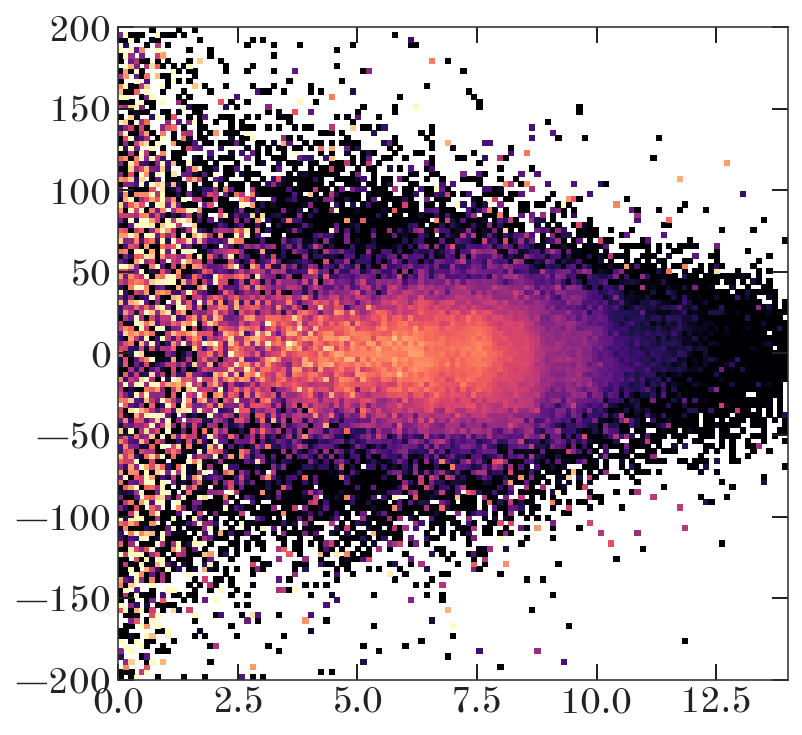

In [325]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

stat = binned_statistic_2d(Rg.value, galcen.v_z.value,
                           nn['M_H'][z_mask],
                           bins=(np.linspace(0, 14, 128),
                                 np.linspace(-200, 200, 128)))

pcl = np.nanpercentile(nn['M_H'][z_mask], [15, 85])
ax.pcolormesh(stat.x_edge, stat.y_edge,
              stat.statistic.T,
              vmin=pcl[0], vmax=pcl[1])

# ax.set_xlim(0, 20)
# ax.set_ylim(-250, 250)

In [316]:
mw = gp.MilkyWayPotential()

In [327]:
derp = gd.PhaseSpacePosition([12.5, 0, 0]*u.kpc,
                             [0, 240, 100]*u.km/u.s)
orbit = mw.integrate_orbit(derp, dt=0.5, t1=0, t2=8*u.Gyr)

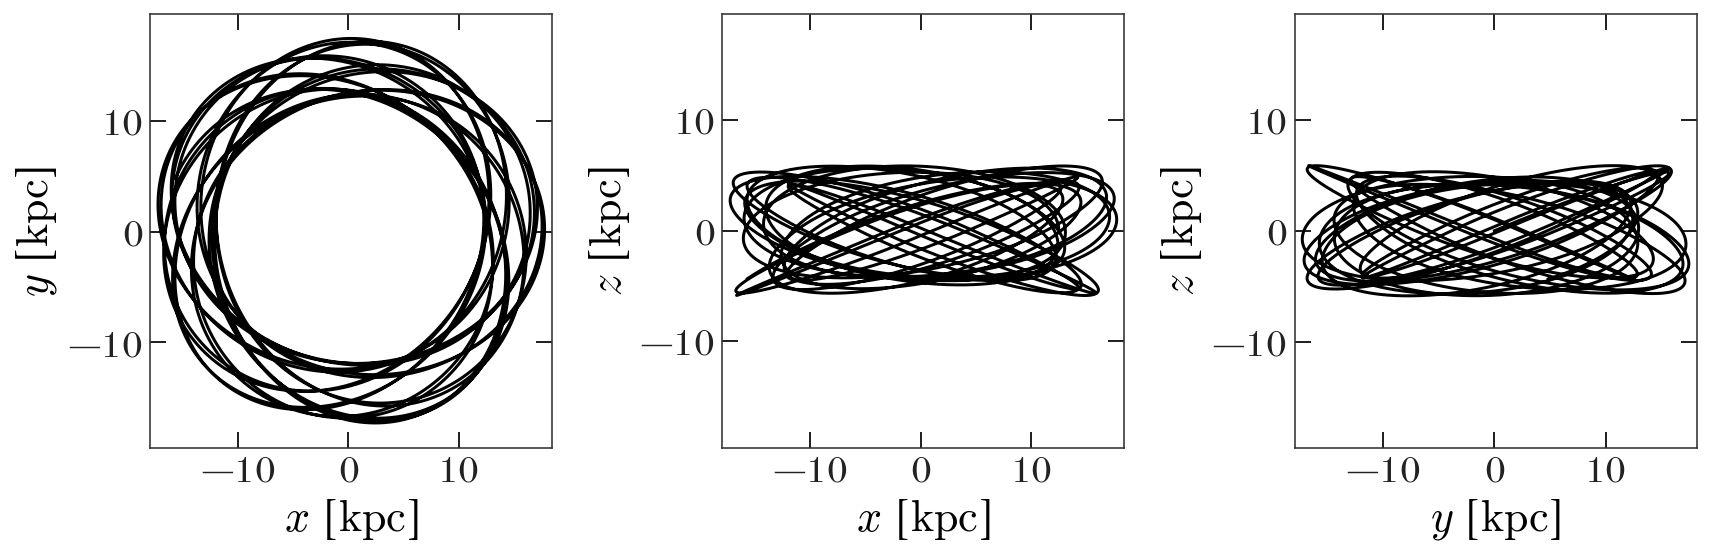

In [328]:
_ = orbit.plot()

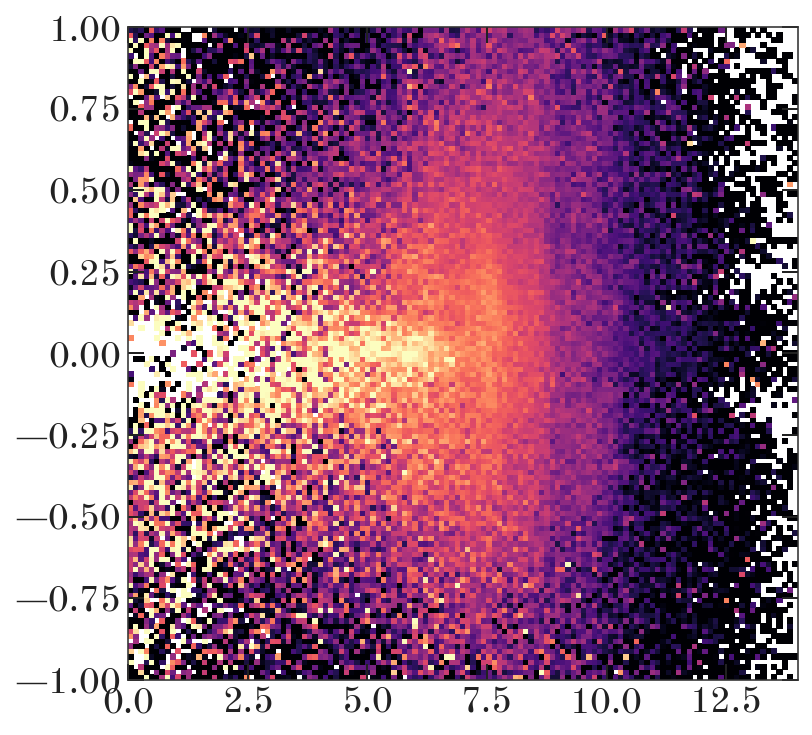

In [315]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

stat = binned_statistic_2d(Rg.value, galcen.z.to_value(u.kpc),
                           nn['M_H'][z_mask],
                           bins=(np.linspace(0, 14, 128),
                                 np.linspace(-1., 1, 128)))

pcl = np.nanpercentile(nn['M_H'][z_mask], [15, 85])
ax.pcolormesh(stat.x_edge, stat.y_edge,
              stat.statistic.T,
              vmin=pcl[0], vmax=pcl[1])